### Objective: 

Using ARIMA, forecast Nominal GDP of the state of Bihar for the next 10 years

In [11]:
#Importing dependencies

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [12]:
#Importing the dataset and checking the first few rows

data = pd.read_csv(r'E:\BI_and_Analytics\1_UC\Capstone_Project\Final_Files\Dataset\bh_gsdp_data.csv')
data.head()

,Year,NominalGSDP
0,1980,2625
1,1981,3008
2,1982,2923
3,1983,3645
4,1984,4102


Note: Year 1980 refers to Financial Year 1980-81, and so on

In [13]:
#Checking the datatype of the columns in the dataset

data.dtypes

Year           int64
NominalGSDP    int64
dtype: object

In [14]:
#Converting the 'Year' column to datetime variable and using it as an index

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
data = pd.read_csv(r'E:\BI_and_Analytics\1_UC\Capstone_Project\Final_Files\Dataset\bh_gsdp_data.csv', 
                   parse_dates=['Year'], index_col='Year',date_parser=dateparse)
data.head()

,NominalGSDP
Year,
1980-01-01,2625
1981-01-01,3008
1982-01-01,2923
1983-01-01,3645
1984-01-01,4102


In [15]:
#Checking the index and its datatype

data.index

DatetimeIndex(['1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1984-01-01', '1985-01-01', '1986-01-01', '1987-01-01',
               '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01'],
              dtype='datetime64[ns]', name='Year', freq=None)

In [16]:
#Convert the 'NominalGSDP' column into a Series object for convenience later on

ts = data["NominalGSDP"]
ts.head

<bound method NDFrame.head of Year
1980-01-01      2625
1981-01-01      3008
1982-01-01      2923
1983-01-01      3645
1984-01-01      4102
1985-01-01      4398
1986-01-01      5388
1987-01-01      6097
1988-01-01      7162
1989-01-01      7903
1990-01-01      8870
1991-01-01     16694
1992-01-01     18359
1993-01-01     22812
1994-01-01     25945
1995-01-01     24483
1996-01-01     32541
1997-01-01     33662
1998-01-01     39033
1999-01-01     50174
2000-01-01     57242
2001-01-01     57657
2002-01-01     64965
2003-01-01     66174
2004-01-01     77781
2005-01-01     82490
2006-01-01    100737
2007-01-01    113680
2008-01-01    142279
2009-01-01    162923
2010-01-01    203555
2011-01-01    247144
2012-01-01    282368
2013-01-01    317101
2014-01-01    373920
Name: NominalGSDP, dtype: int64>

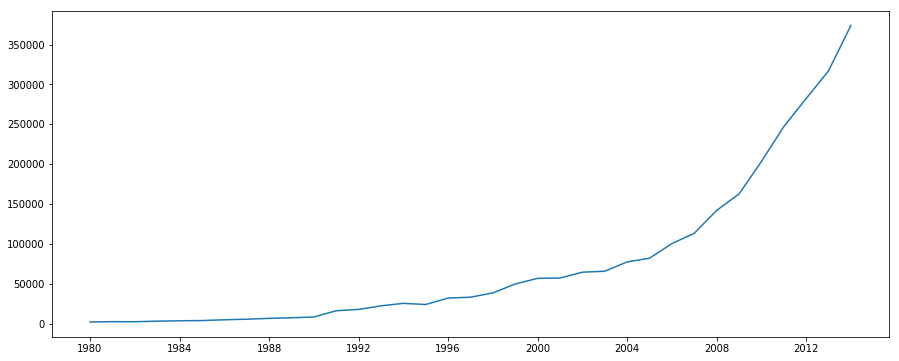

In [17]:
#Plotting the data

plt.plot(ts)

ARIMA can be applied only if the time series is Stationary,i.e. it should have constant statistical properties over time, which are:

1) Constant Mean
2) Constant Variance
3) An Autocovariance that does not depend on Time

The above time series clearly doesn't appear to be have constant mean/variance. However, instead of visual inspection, we can also check if a time series is stationary or not by performing Dickey-Fuller Test

In [18]:
#Defining a function for checking the stationarity of the data using rolling mean, rolling standard deviation 
#(as proxy for variance)and Dickey-Fuller Test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=5).mean()
    rolstd = timeseries.rolling(window=5).std()

    #Plotting rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Performing Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

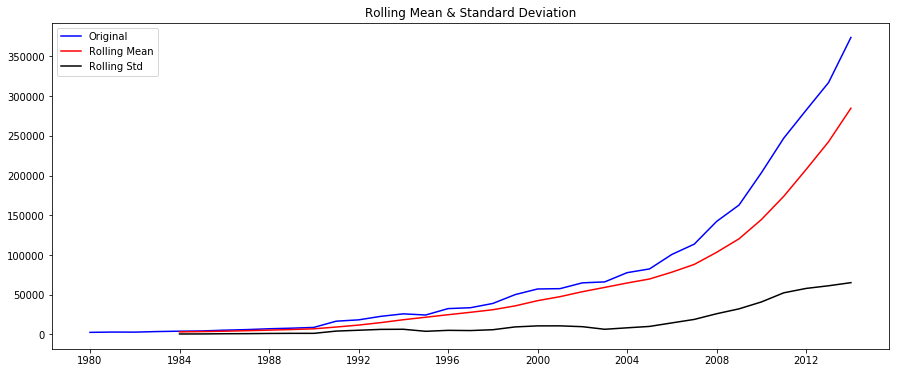

Results of Dickey-Fuller Test:
Test Statistic                 14.439462
p-value                         1.000000
#Lags Used                      0.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [19]:
test_stationarity(ts)

Clearly, both the mean and standard deviation are increasing over time. Additionally, the p-value is > 0.05, which means the time series is not stationary

We need to make the time series stationary through transformation before performing ARIMA on it. In this case, it appears that the data has only trend and no seasonality, and hence we need to eliminate the trend.

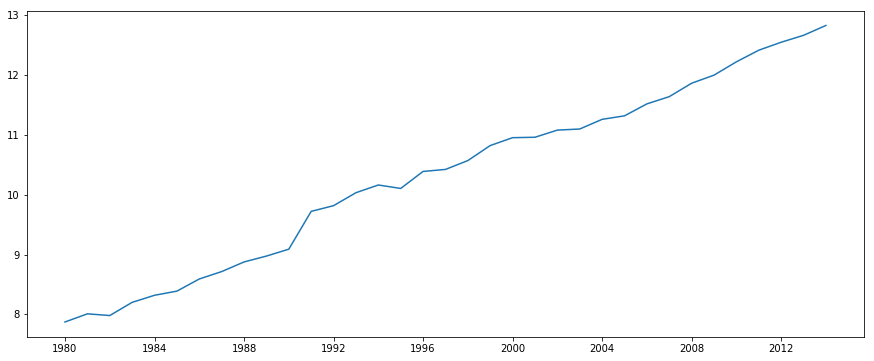

In [20]:
#Taking log of time series and plotting it

ts_log = np.log(ts)
plt.plot(ts_log)

Clearly the series is still not stationary. There are different ways of eliminating this trend - subtracting moving average, or expontial weighted moving average or simply the last number (first order differencing) from the log(series). Here, we are going to use first order differencing, and see if the series becomes stationary. If it doesn't, then we may have to try 2nd order differencing or some other technique.

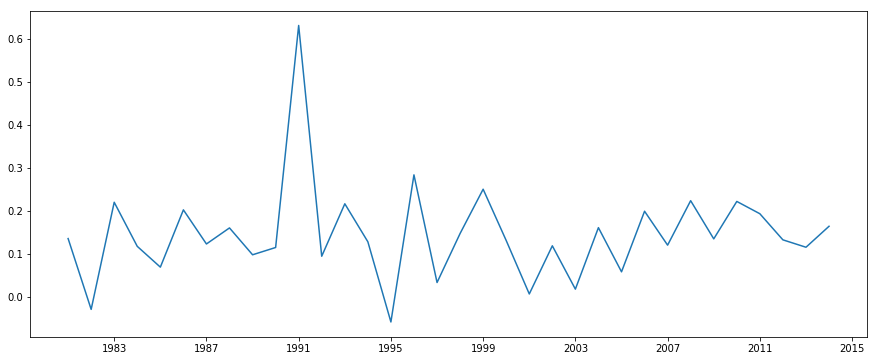

In [285]:
#First Order Differencing

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

The trend seems to have been eliminated. Let's check the stationarity of the series again.

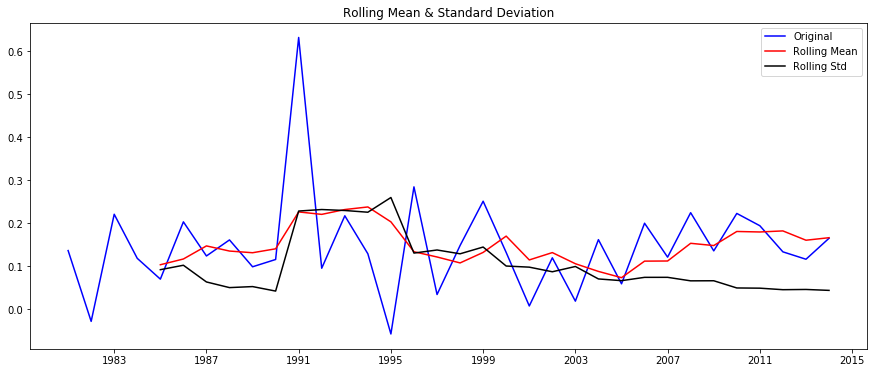

Results of Dickey-Fuller Test:
Test Statistic                 -3.302223
p-value                         0.014779
#Lags Used                      3.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


In [286]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

The trend has been eliminated. The series is now stationary

In [287]:
from statsmodels.tsa.arima_model import ARIMA

In [288]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [289]:
lag_acf = acf(ts_log_diff, nlags=30)
lag_pacf = pacf(ts_log_diff, nlags=30, method='ols')

Text(0.5,1,'Autocorrelation Function')

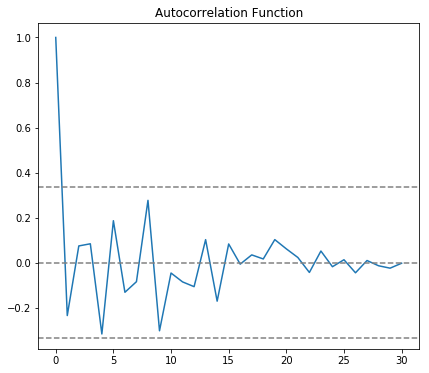

In [290]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

The value of 'q' (one of the inputs to ARIMA Model) can be manually determined by identifyting the lag value where the ACF chart crosses the upper confidence interval for the first time. In the above chart, it's close to 2

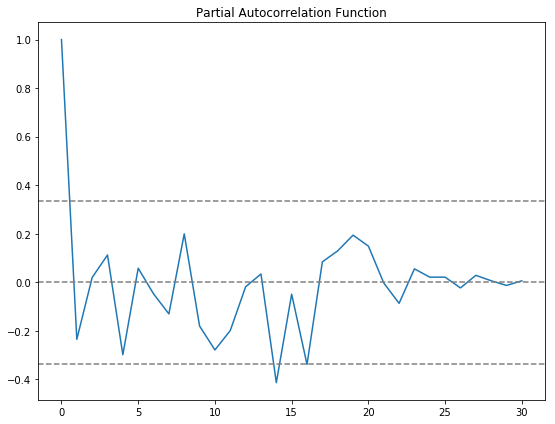

In [291]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The value of 'p' (one of the inputs to ARIMA Model) can be manually determined by identifyting the lag value where the PACF chart crosses the upper confidence interval for the first time. In the above chart, it's close to 2

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 0.4182')

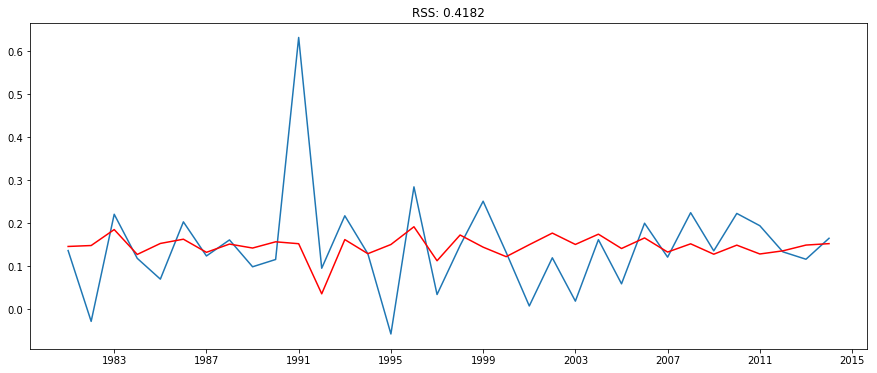

In [292]:
model = ARIMA(ts_log, order=(1, 1, 1))  
#model = auto_arima(ts_log_diff, trace=True, error_action='ignore', suppress_warnings=True)
results_ARIMA = model.fit(disp=0)  
#results_ARIMA = model.fit  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [293]:
results_ARIMA.fittedvalues[0:9]

Year
1981-01-01    0.145757
1982-01-01    0.147939
1983-01-01    0.185096
1984-01-01    0.127186
1985-01-01    0.152770
1986-01-01    0.162667
1987-01-01    0.132115
1988-01-01    0.151323
1989-01-01    0.142084
dtype: float64

In [294]:
#Taking back to the original scale

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Year
1981-01-01    0.145757
1982-01-01    0.147939
1983-01-01    0.185096
1984-01-01    0.127186
1985-01-01    0.152770
dtype: float64

In [295]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Year
1981-01-01    0.145757
1982-01-01    0.293697
1983-01-01    0.478793
1984-01-01    0.605979
1985-01-01    0.758749
dtype: float64

In [296]:
#Creating a series with all values as base number

predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


Year
1980-01-01    7.872836
1981-01-01    7.872836
1982-01-01    7.872836
1983-01-01    7.872836
1984-01-01    7.872836
dtype: float64

In [297]:
#Adding differences obtained earlier to the base series

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Year
1980-01-01    7.872836
1981-01-01    8.018593
1982-01-01    8.166533
1983-01-01    8.351629
1984-01-01    8.478815
dtype: float64

In [298]:
#Taking exponential

predictions_ARIMA = np.exp(predictions_ARIMA_log)

In [299]:
#Comparing predictions with actual values

ts[1:10],predictions_ARIMA[1:10]

(Year
 1981-01-01    3008
 1982-01-01    2923
 1983-01-01    3645
 1984-01-01    4102
 1985-01-01    4398
 1986-01-01    5388
 1987-01-01    6097
 1988-01-01    7162
 1989-01-01    7903
 Name: NominalGSDP, dtype: int64, Year
 1981-01-01     3036.902750
 1982-01-01     3521.114838
 1983-01-01     4237.079004
 1984-01-01     4811.744320
 1985-01-01     5605.956843
 1986-01-01     6596.219185
 1987-01-01     7527.869393
 1988-01-01     8757.713220
 1989-01-01    10094.784547
 dtype: float64)

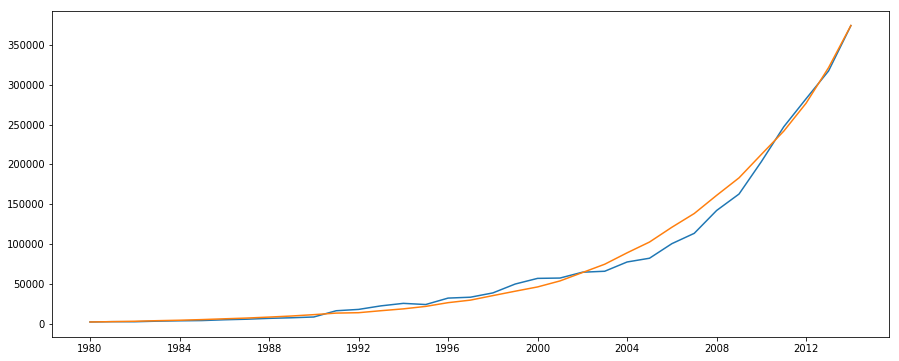

In [300]:
##Comparing predictions with actual values by plotting them

plt.plot(ts)
plt.plot(predictions_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

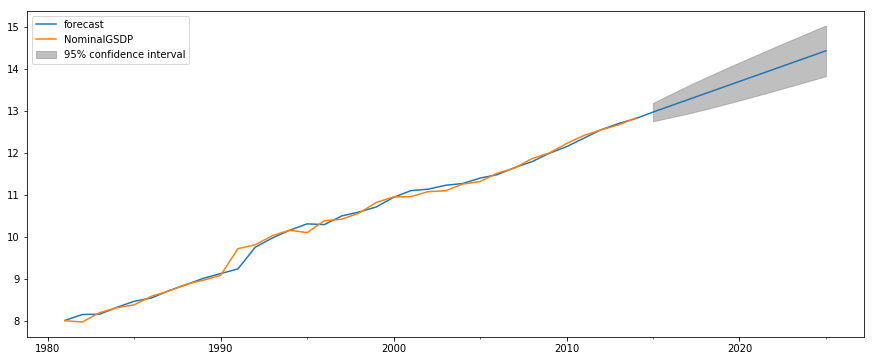

In [301]:
#Forecasting for the next 10 years

results_ARIMA.plot_predict(1,45)
x=results_ARIMA.forecast(steps=10)

In [302]:
x[0]

array([12.97297343, 13.11995493, 13.26538503, 13.41122973, 13.55696363,
       13.70272715, 13.84848274, 13.99424046, 14.13999761, 14.28575491])

In [303]:
forecast = np.exp(x[0])
forecast[0:9]

array([ 430616.60555572,  498797.22557035,  576877.39173918,
        667456.65525888,  772172.79604059,  893344.12601021,
       1033521.79255678, 1195697.74230317, 1383320.88714802])

In [304]:
data = {'Year':[2015,2016,2017,2018,2019,2020,2021,2022,2023,2024],'nominalGSDP':forecast}
forecast_df = pd.DataFrame(data)
forecast_df
#plt.plot(forecast_df)

,Year,nominalGSDP
0,2015,4.306166e+05
1,2016,4.987972e+05
2,2017,5.768774e+05
3,2018,6.674567e+05
4,2019,7.721728e+05
5,2020,8.933441e+05
6,2021,1.033522e+06
7,2022,1.195698e+06
8,2023,1.383321e+06
9,2024,1.600385e+06


In [305]:
forecast_df['Year']  = pd.to_datetime(forecast_df['Year'],format='%Y')
forecast_ts = forecast_df.set_index('Year')
forecast_ts.head()

,nominalGSDP
Year,
2015-01-01,430616.605556
2016-01-01,498797.225570
2017-01-01,576877.391739
2018-01-01,667456.655259
2019-01-01,772172.796041


In [308]:
forecast_ts.dtypes

nominalGSDP    float64
dtype: object

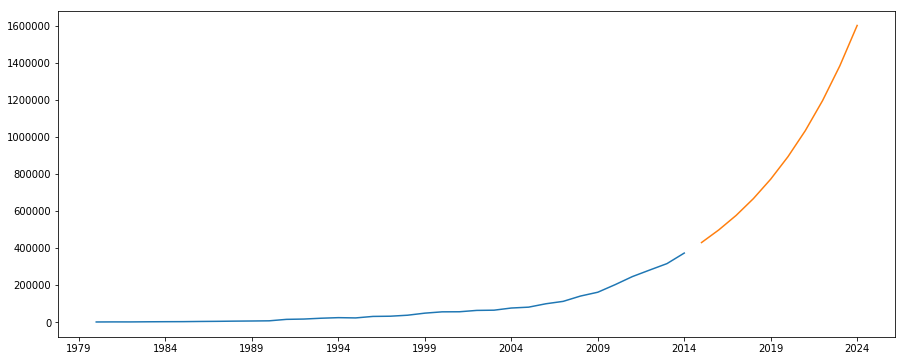

In [309]:
plt.plot(ts)
plt.plot(forecast_ts)

In [311]:
#Exporting Data

forecast_ts.to_csv(r'E:\BI_and_Analytics\1_UC\Capstone_Project\Final_Files\Output_and_Visualizations\Forecast_ARIMA_1_State_bihar.csv') 